In [519]:
import pandas as pd
import numpy as np
from collections import defaultdict
import math
import re

# Добавим новых фичей

In [520]:
# Считываю датасет
dataset = pd.read_excel("../datasets/data_weather.xlsx", index_col=[0])

Разобью dep_datetime и arr_datetime на dep_date, dep_time, arr_date, arr_time.

In [521]:
dataset['dep_date'] = [pd.Timestamp(str(item).split()[0]) for item in dataset['dep_datetime']]
dataset['dep_time'] = [pd.to_datetime(str(item).split()[1], format='%H:%M:%S').time() if len(str(item).split()) > 1 else np.nan for item in dataset['dep_datetime']]
dataset['arr_date'] = [pd.Timestamp(str(item).split()[0]) for item in dataset['arr_datetime']]
dataset['arr_time'] = [pd.to_datetime(str(item).split()[1], format='%H:%M:%S').time() if len(str(item).split()) > 1 else np.nan for item in dataset['arr_datetime']]

del dataset['dep_datetime']
del dataset['arr_datetime']

In [522]:
dataset.head()

,center,flight_id,uav_type,duration_min,takeoff_lat,takeoff_lon,landing_lat,landing_lon,wind_dir,wind_speed,Т(С),f(%),R(мм),R24(мм),dep_date,dep_time,arr_date,arr_time
22983,Тюмень,7.771444e+09,BLA,960.0,60.400000,69.816667,60.400000,69.816667,СЗ,2.166667,-12.216667,72.5,0.0,NaN,2024-01-01,00:00:00,2024-01-01,16:00:00
23004,Тюмень,7.771445e+09,BLA,960.0,61.100000,72.766667,61.100000,72.766667,СЗ,2.166667,-12.216667,72.5,0.0,NaN,2024-01-01,00:00:00,2024-01-01,16:00:00
23003,Тюмень,7.771445e+09,BLA,960.0,60.950000,73.000000,60.950000,73.000000,СЗ,2.166667,-12.216667,72.5,0.0,NaN,2024-01-01,00:00:00,2024-01-01,16:00:00
23002,Тюмень,7.771445e+09,BLA,960.0,61.033333,73.866667,61.033333,73.866667,СЗ,2.166667,-12.216667,72.5,0.0,NaN,2024-01-01,00:00:00,2024-01-01,16:00:00
22999,Тюмень,7.771445e+09,BLA,960.0,60.816667,72.816667,60.816667,72.816667,СЗ,2.166667,-12.216667,72.5,0.0,NaN,2024-01-01,00:00:00,2024-01-01,16:00:00


In [523]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128844 entries, 22983 to 128280
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   center        128844 non-null  object        
 1   flight_id     120031 non-null  float64       
 2   uav_type      128685 non-null  object        
 3   duration_min  117773 non-null  float64       
 4   takeoff_lat   126403 non-null  float64       
 5   takeoff_lon   126403 non-null  float64       
 6   landing_lat   126398 non-null  float64       
 7   landing_lon   126398 non-null  float64       
 8   wind_dir      112870 non-null  object        
 9   wind_speed    111556 non-null  float64       
 10  Т(С)          112870 non-null  float64       
 11  f(%)          112870 non-null  float64       
 12  R(мм)         45477 non-null   float64       
 13  R24(мм)       0 non-null       float64       
 14  dep_date      120351 non-null  datetime64[ns]
 15  dep_time      1203

Добавлю обозначение сезонности (season), буду ориантироваться на arr_date.

In [524]:
def get_season(month):
    if month in [12, 1, 2]: return 'winter'
    elif month in [3, 4, 5]: return 'spring'
    elif month in [6, 7, 8]: return 'summer'
    else: return 'autumn'

In [525]:
dataset["season"] = [get_season(item.month) for item in dataset["arr_date"]]

In [526]:
dataset.head()

,center,flight_id,uav_type,duration_min,takeoff_lat,takeoff_lon,landing_lat,landing_lon,wind_dir,wind_speed,Т(С),f(%),R(мм),R24(мм),dep_date,dep_time,arr_date,arr_time,season
22983,Тюмень,7.771444e+09,BLA,960.0,60.400000,69.816667,60.400000,69.816667,СЗ,2.166667,-12.216667,72.5,0.0,NaN,2024-01-01,00:00:00,2024-01-01,16:00:00,winter
23004,Тюмень,7.771445e+09,BLA,960.0,61.100000,72.766667,61.100000,72.766667,СЗ,2.166667,-12.216667,72.5,0.0,NaN,2024-01-01,00:00:00,2024-01-01,16:00:00,winter
23003,Тюмень,7.771445e+09,BLA,960.0,60.950000,73.000000,60.950000,73.000000,СЗ,2.166667,-12.216667,72.5,0.0,NaN,2024-01-01,00:00:00,2024-01-01,16:00:00,winter
23002,Тюмень,7.771445e+09,BLA,960.0,61.033333,73.866667,61.033333,73.866667,СЗ,2.166667,-12.216667,72.5,0.0,NaN,2024-01-01,00:00:00,2024-01-01,16:00:00,winter
22999,Тюмень,7.771445e+09,BLA,960.0,60.816667,72.816667,60.816667,72.816667,СЗ,2.166667,-12.216667,72.5,0.0,NaN,2024-01-01,00:00:00,2024-01-01,16:00:00,winter


In [527]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128844 entries, 22983 to 128280
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   center        128844 non-null  object        
 1   flight_id     120031 non-null  float64       
 2   uav_type      128685 non-null  object        
 3   duration_min  117773 non-null  float64       
 4   takeoff_lat   126403 non-null  float64       
 5   takeoff_lon   126403 non-null  float64       
 6   landing_lat   126398 non-null  float64       
 7   landing_lon   126398 non-null  float64       
 8   wind_dir      112870 non-null  object        
 9   wind_speed    111556 non-null  float64       
 10  Т(С)          112870 non-null  float64       
 11  f(%)          112870 non-null  float64       
 12  R(мм)         45477 non-null   float64       
 13  R24(мм)       0 non-null       float64       
 14  dep_date      120351 non-null  datetime64[ns]
 15  dep_time      1203

## В этот момент можно почистить данные, сделаны все удобные предобработки

In [528]:
import missingno as msno

In [529]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128844 entries, 22983 to 128280
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   center        128844 non-null  object        
 1   flight_id     120031 non-null  float64       
 2   uav_type      128685 non-null  object        
 3   duration_min  117773 non-null  float64       
 4   takeoff_lat   126403 non-null  float64       
 5   takeoff_lon   126403 non-null  float64       
 6   landing_lat   126398 non-null  float64       
 7   landing_lon   126398 non-null  float64       
 8   wind_dir      112870 non-null  object        
 9   wind_speed    111556 non-null  float64       
 10  Т(С)          112870 non-null  float64       
 11  f(%)          112870 non-null  float64       
 12  R(мм)         45477 non-null   float64       
 13  R24(мм)       0 non-null       float64       
 14  dep_date      120351 non-null  datetime64[ns]
 15  dep_time      1203

<Axes: >

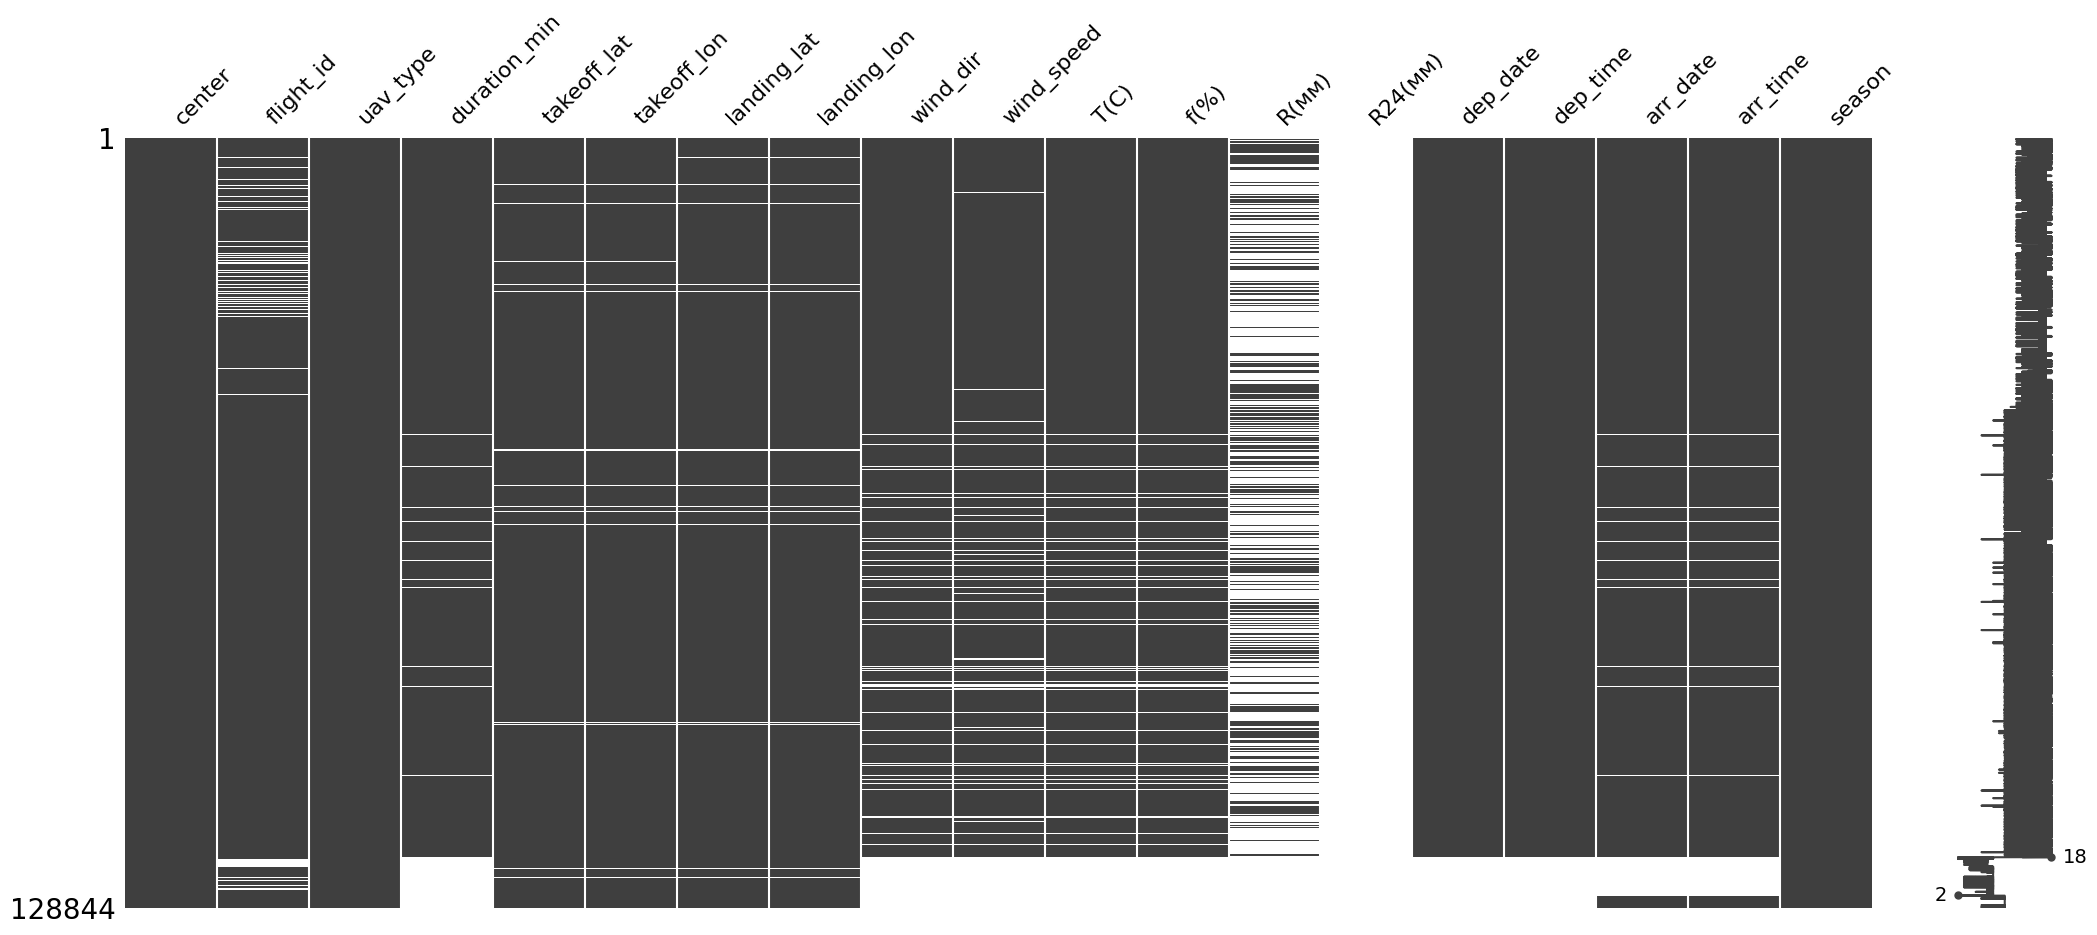

In [530]:
msno.matrix(dataset)

Удаляю "хвостовые" пропуски, появивишеся из-за пропусков в duration_min

In [531]:
dataset = dataset.loc[:dataset['duration_min'].last_valid_index()]

<Axes: >

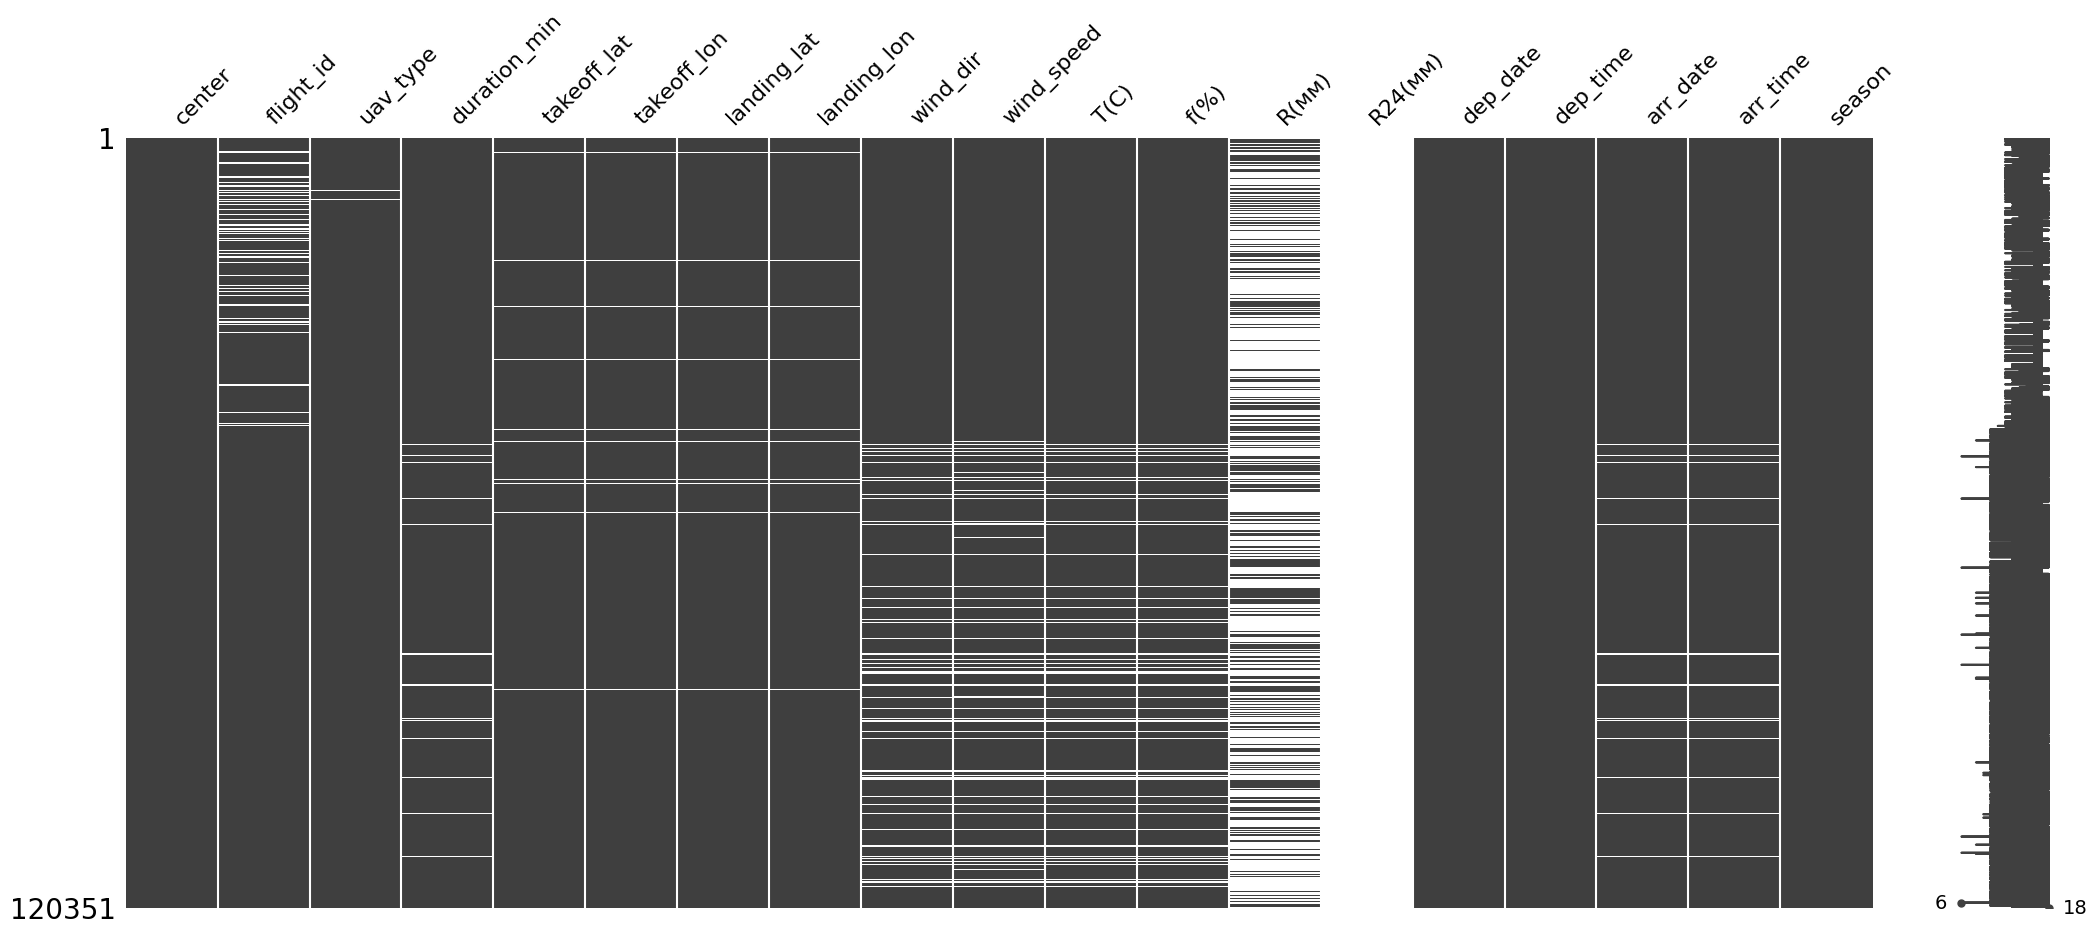

In [532]:
msno.matrix(dataset)

Удаляю R(мм), R24(мм) слишком мало данных

In [533]:
del dataset["R(мм)"]
del dataset["R24(мм)"]

Сначала заполню T(C), f(%), wind_speed - это первое что пришло в голову. Буду интерпалировать кубическим сплайном в пределе сезона (была мысль заполнить предыдущим известным значнием, но тогда рискую наткнуться на ситуацию, когда много пропусков идут подряд). А скорость ветра буду интерполировать линейно, чтобы избежать отрицательных значений.

In [534]:
dataset["Т(С)"] = dataset.groupby("season")["Т(С)"].transform(
    lambda x: x.interpolate(method="cubic")
)

dataset["f(%)"] = dataset.groupby("season")["f(%)"].transform(
    lambda x: x.interpolate(method="cubic")
)

dataset["wind_speed"] = dataset.groupby("season")["wind_speed"].transform(
    lambda x: x.interpolate(method='linear')
)

<Axes: >

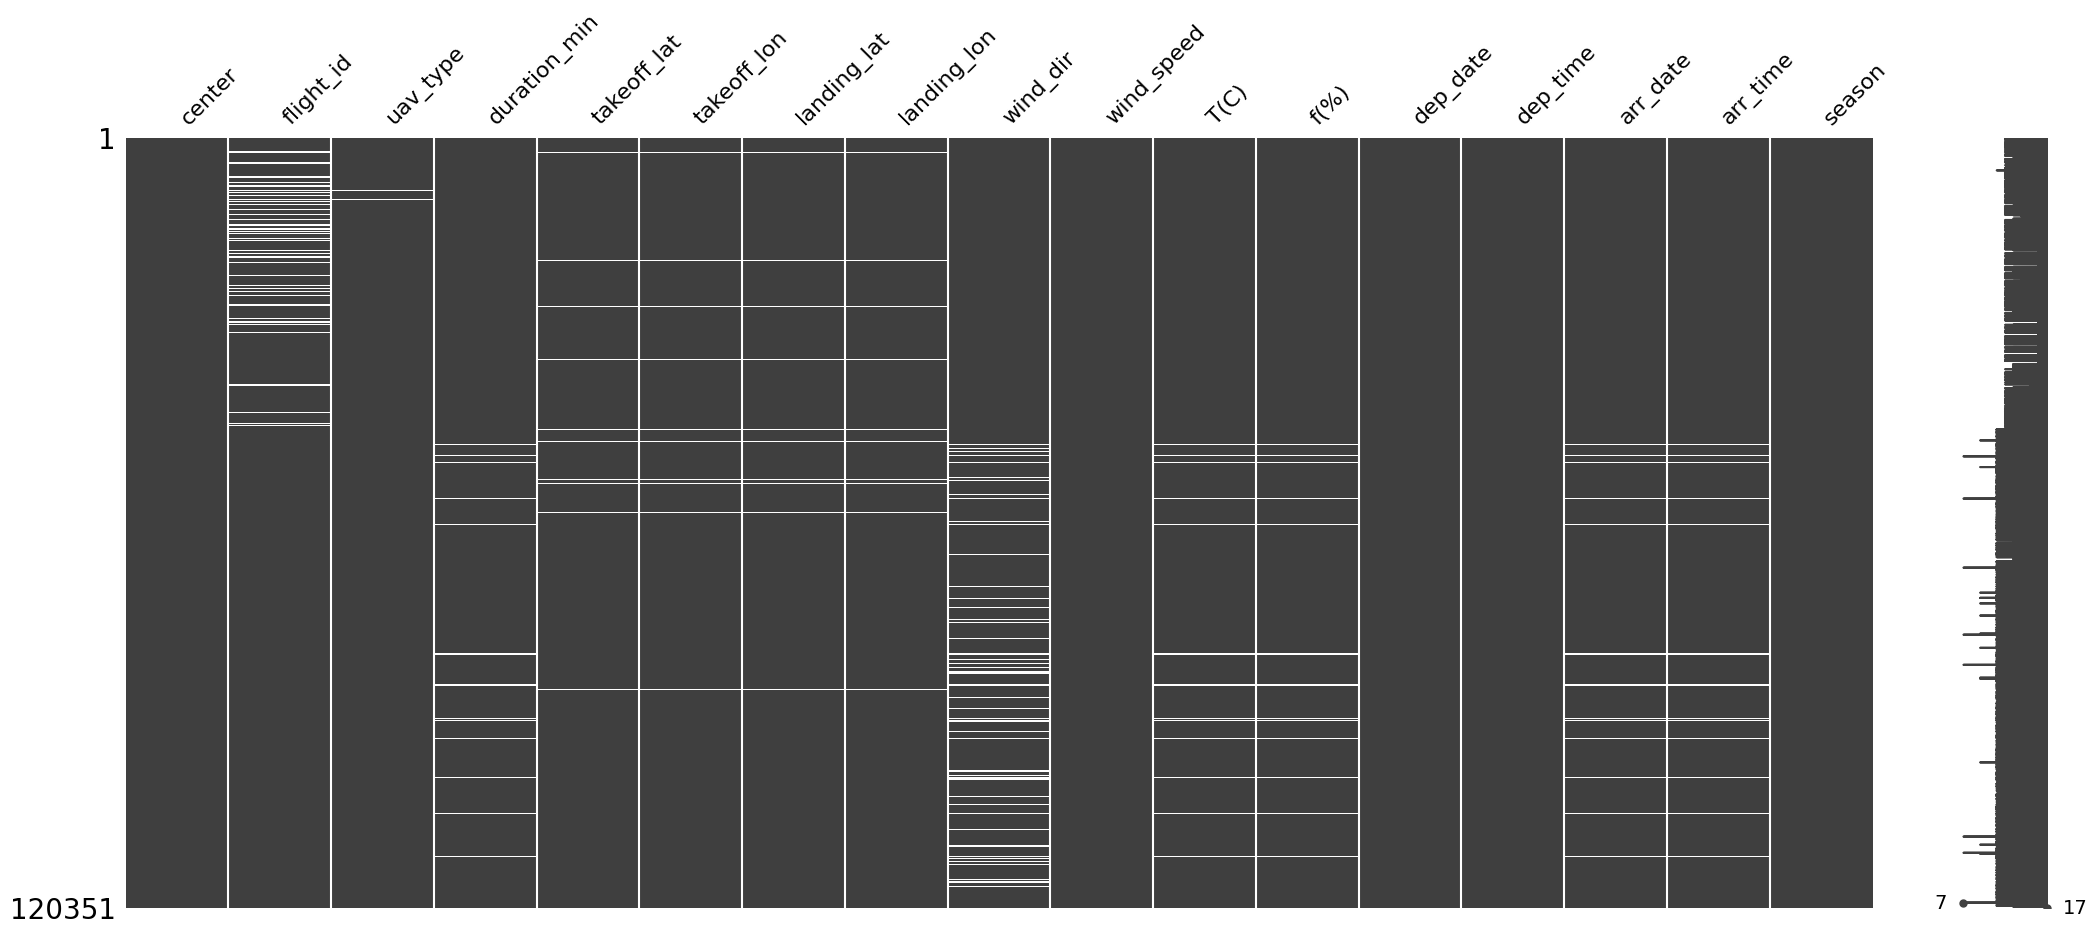

In [535]:
msno.matrix(dataset)

In [536]:
# нужно интерполировать wind_dir, но изначально там хранятся категориальные данные - проблема. Буду преобразовывать и т.д. 

mapping = {
    "С": 0, "СВ": 45, "В": 90, "ЮВ": 135,
    "Ю": 180, "ЮЗ": 225, "З": 270, "СЗ": 315, "штиль": np.nan
}

wind_dir_deg = dataset["wind_dir"].map(mapping).sort_index()

# перевод в радианы
wind_dir_rad = np.deg2rad(wind_dir_deg)

# вектора
x = np.cos(wind_dir_rad)
y = np.sin(wind_dir_rad)

# интерполяция
x_interp = pd.Series(x).interpolate()
y_interp = pd.Series(y).interpolate()

# обратно в угол
angles = np.arctan2(y_interp, x_interp)
angles_deg = (np.rad2deg(angles) + 360) % 360

dataset["wind_dir"] = angles_deg

<Axes: >

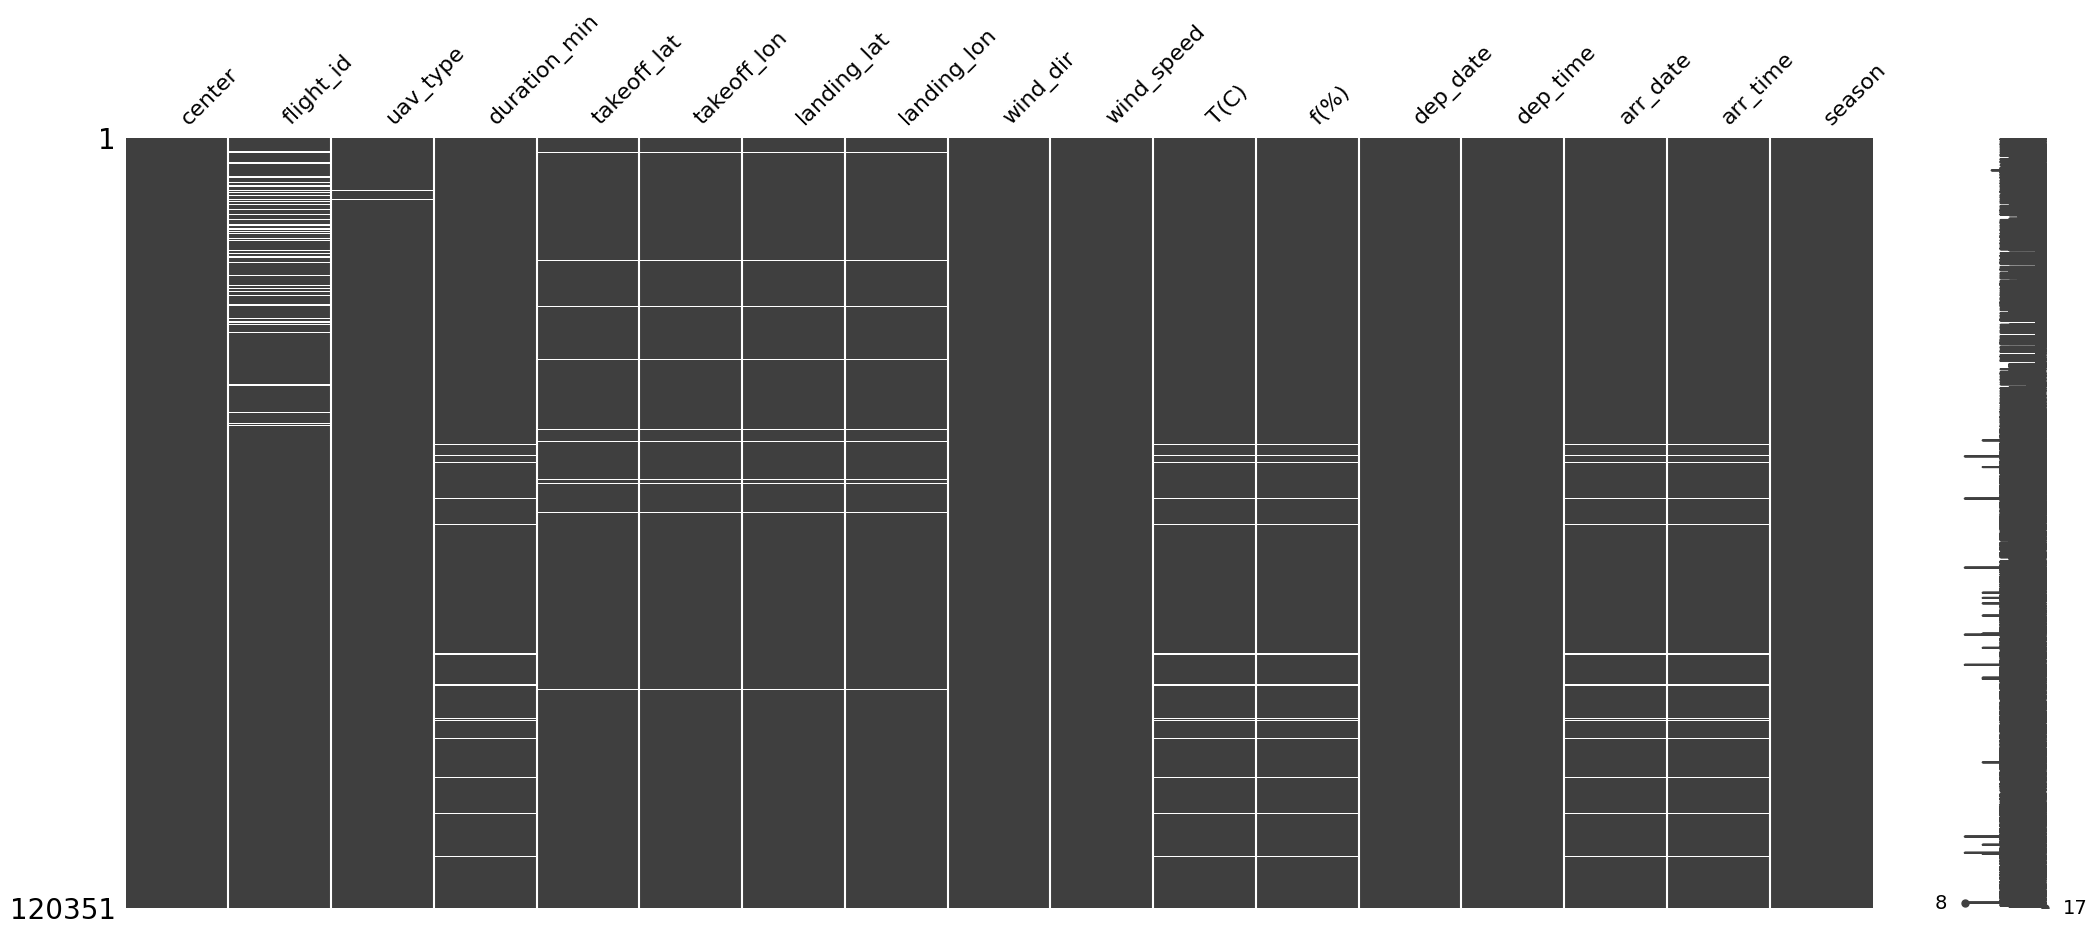

In [537]:
msno.matrix(dataset)

Ещё есть проблема с типами дронов - ставлю на то, что это ошибки записи, которые нужно подкорректировать и почистить.

In [538]:
dataset["uav_type"].unique()

array(['BLA', '3BLA', '2BLA', '1', nan, 'BPLA', '2', 'DJI', '5BLA',
       'BLA2', ',,FANTOM', '4BLA', '8BLA', 'BLA_x000D_', '9BLA',
       'BLAOPR/TRACEAIR', '6BLA', 'BLA3', '13BLA', '12BLA', 'BWS', '7BLA',
       '17BLA', '11BLA', '3', '20BLA', '08BLA?', '15BLA', '10BLA', '1BLA',
       '05BLA', '08BLA', '5BLA_x000D_', '21BLA', '09BLA', '14BLA',
       '07BLA', '06BLA', 'BLAALXBATROS', 'BLA,', '04BLA', '?', '4',
       'ORLAN-10', '0', 'BLA,,GEOSKAN,,', 'КВАДРОКОПТЕР', 'SHAR', '32BLA',
       '22BLA', 'BLA200', '200BLA', 'AER', '18BLA', '19BLA', '24BLA',
       '2AER', '3AER', '9AER', '35BLA', '5AER', '8AER', '16BLA', '23BLA',
       '4AER', '6AER', '26BLA', '16AER', '25BLA', '29BLA', '27BLA',
       '43BLA', '40BLA', '10AER', '12AER', '11AER', '19AER', '36BLA',
       '45BLA', '47BLA', '50BLA'], dtype=object)

In [539]:
def normalize_drone_type(x):
    if pd.isna(x):
        return np.nan
    x = str(x).upper()
    x = re.sub(r'[^A-ZА-Я]', '', x)
    # выделяю базовое название
    if 'BLA' in x:
        return 'BLA'
    elif 'AER' in x:
        return 'AER'
    elif 'DJI' in x:
        return 'DJI'
    elif 'ORLAN' in x:
        return 'ORLAN'
    elif 'FANTOM' in x:
        return 'FANTOM'
    elif 'SHAR' in x:
        return 'SHAR'
    elif 'КВАДРОКОПТЕР' in x:
        return 'BLA'
    elif 'BWS' in x:
        return 'BWS'
    elif " ":
        return np.nan
    else:
        return
    
dataset["uav_type"] = dataset["uav_type"].map(normalize_drone_type)

Добавлю показатель загруженности области (air_traffic_load)

In [540]:
region_area_by_city = {
    "Тюмень": 1464173,            
    "Москва": 2561.5,             
    "Красноярск": 2_366_797,      
    "Магадан": 462_464,           
    "Якутск": 3_083_523,          
    "Иркутск": 774_846,           
    "Новосибирск": 177_756,       
    "Ростов": 100_967,            
    "Екатеринбург": 194_307,      
    "Калининград": 15_125,        
    "Санкт-Петербург": 1_403,     
    "Самара": 53_565,              
    "Хабаровск": 787_633,          
    "Симферополь": 26_081         
}

In [541]:
traffic_cnt = dataset.groupby('center').count()["season"]
air_traffic_load = defaultdict(int)

for idx in traffic_cnt.index:
    air_traffic_load[idx] = traffic_cnt[idx]/region_area_by_city[idx]

air_traffic_load = pd.DataFrame(list(air_traffic_load.items()), columns=["center", "air_traffic_load"])

dataset = dataset.merge(air_traffic_load, on="center", how="left")

In [542]:
dataset.head()

,center,flight_id,uav_type,duration_min,takeoff_lat,takeoff_lon,landing_lat,landing_lon,wind_dir,wind_speed,Т(С),f(%),dep_date,dep_time,arr_date,arr_time,season,air_traffic_load
0,Тюмень,7.771444e+09,BLA,960.0,60.400000,69.816667,60.400000,69.816667,315.0,2.166667,-12.216667,72.5,2024-01-01,00:00:00,2024-01-01,16:00:00,winter,0.027036
1,Тюмень,7.771445e+09,BLA,960.0,61.100000,72.766667,61.100000,72.766667,315.0,2.166667,-12.216667,72.5,2024-01-01,00:00:00,2024-01-01,16:00:00,winter,0.027036
2,Тюмень,7.771445e+09,BLA,960.0,60.950000,73.000000,60.950000,73.000000,315.0,2.166667,-12.216667,72.5,2024-01-01,00:00:00,2024-01-01,16:00:00,winter,0.027036
3,Тюмень,7.771445e+09,BLA,960.0,61.033333,73.866667,61.033333,73.866667,315.0,2.166667,-12.216667,72.5,2024-01-01,00:00:00,2024-01-01,16:00:00,winter,0.027036
4,Тюмень,7.771445e+09,BLA,960.0,60.816667,72.816667,60.816667,72.816667,315.0,2.166667,-12.216667,72.5,2024-01-01,00:00:00,2024-01-01,16:00:00,winter,0.027036


Можно добавить и само количество полетов в регионе (traffic_cnt)

In [543]:
dataset = dataset.merge(traffic_cnt.to_frame(name="traffic_cnt"), left_on="center", right_index=True)

In [544]:
dataset.head()

,center,flight_id,uav_type,duration_min,takeoff_lat,takeoff_lon,landing_lat,landing_lon,wind_dir,wind_speed,Т(С),f(%),dep_date,dep_time,arr_date,arr_time,season,air_traffic_load,traffic_cnt
0,Тюмень,7.771444e+09,BLA,960.0,60.400000,69.816667,60.400000,69.816667,315.0,2.166667,-12.216667,72.5,2024-01-01,00:00:00,2024-01-01,16:00:00,winter,0.027036,39586
1,Тюмень,7.771445e+09,BLA,960.0,61.100000,72.766667,61.100000,72.766667,315.0,2.166667,-12.216667,72.5,2024-01-01,00:00:00,2024-01-01,16:00:00,winter,0.027036,39586
2,Тюмень,7.771445e+09,BLA,960.0,60.950000,73.000000,60.950000,73.000000,315.0,2.166667,-12.216667,72.5,2024-01-01,00:00:00,2024-01-01,16:00:00,winter,0.027036,39586
3,Тюмень,7.771445e+09,BLA,960.0,61.033333,73.866667,61.033333,73.866667,315.0,2.166667,-12.216667,72.5,2024-01-01,00:00:00,2024-01-01,16:00:00,winter,0.027036,39586
4,Тюмень,7.771445e+09,BLA,960.0,60.816667,72.816667,60.816667,72.816667,315.0,2.166667,-12.216667,72.5,2024-01-01,00:00:00,2024-01-01,16:00:00,winter,0.027036,39586


In [545]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120351 entries, 0 to 120350
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   center            120351 non-null  object        
 1   flight_id         113705 non-null  float64       
 2   uav_type          119908 non-null  object        
 3   duration_min      117773 non-null  float64       
 4   takeoff_lat       118301 non-null  float64       
 5   takeoff_lon       118301 non-null  float64       
 6   landing_lat       118292 non-null  float64       
 7   landing_lon       118292 non-null  float64       
 8   wind_dir          120351 non-null  float64       
 9   wind_speed        120351 non-null  float64       
 10  Т(С)              117773 non-null  float64       
 11  f(%)              117773 non-null  float64       
 12  dep_date          120351 non-null  datetime64[ns]
 13  dep_time          120351 non-null  object        
 14  arr_

Добавлю относительную загружнность по регионам (relative_air_traffic_load), то есть отношение количество полётов к максимальному количеству полётов

In [546]:
dataset["relative_air_traffic_load"] = dataset["traffic_cnt"] / max(dataset["traffic_cnt"])

In [547]:
dataset.head()

,center,flight_id,uav_type,duration_min,takeoff_lat,takeoff_lon,landing_lat,landing_lon,wind_dir,wind_speed,Т(С),f(%),dep_date,dep_time,arr_date,arr_time,season,air_traffic_load,traffic_cnt,relative_air_traffic_load
0,Тюмень,7.771444e+09,BLA,960.0,60.400000,69.816667,60.400000,69.816667,315.0,2.166667,-12.216667,72.5,2024-01-01,00:00:00,2024-01-01,16:00:00,winter,0.027036,39586,1.0
1,Тюмень,7.771445e+09,BLA,960.0,61.100000,72.766667,61.100000,72.766667,315.0,2.166667,-12.216667,72.5,2024-01-01,00:00:00,2024-01-01,16:00:00,winter,0.027036,39586,1.0
2,Тюмень,7.771445e+09,BLA,960.0,60.950000,73.000000,60.950000,73.000000,315.0,2.166667,-12.216667,72.5,2024-01-01,00:00:00,2024-01-01,16:00:00,winter,0.027036,39586,1.0
3,Тюмень,7.771445e+09,BLA,960.0,61.033333,73.866667,61.033333,73.866667,315.0,2.166667,-12.216667,72.5,2024-01-01,00:00:00,2024-01-01,16:00:00,winter,0.027036,39586,1.0
4,Тюмень,7.771445e+09,BLA,960.0,60.816667,72.816667,60.816667,72.816667,315.0,2.166667,-12.216667,72.5,2024-01-01,00:00:00,2024-01-01,16:00:00,winter,0.027036,39586,1.0


In [548]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120351 entries, 0 to 120350
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   center                     120351 non-null  object        
 1   flight_id                  113705 non-null  float64       
 2   uav_type                   119908 non-null  object        
 3   duration_min               117773 non-null  float64       
 4   takeoff_lat                118301 non-null  float64       
 5   takeoff_lon                118301 non-null  float64       
 6   landing_lat                118292 non-null  float64       
 7   landing_lon                118292 non-null  float64       
 8   wind_dir                   120351 non-null  float64       
 9   wind_speed                 120351 non-null  float64       
 10  Т(С)                       117773 non-null  float64       
 11  f(%)                       117773 non-null  float64 

Рассчитаю пройденный путь (м) (distance) и скорость дрона (speed) (м/с)

In [549]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # радиус Земли в км
    # переводим в радианы
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)

    a = math.sin(dphi / 2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda / 2)**2
    c = 2 * math.asin(math.sqrt(a))

    return R * c

In [550]:
dataset["distance"] = [
    haversine(
        dataset.loc[i, "takeoff_lat"],
        dataset.loc[i, "takeoff_lon"],
        dataset.loc[i, "landing_lat"],
        dataset.loc[i, "landing_lon"]
    ) * 1000 for i in range(dataset.shape[0])
]

dataset["speed"] = dataset["distance"] / dataset["duration_min"]

In [551]:
dataset.head()

,center,flight_id,uav_type,duration_min,takeoff_lat,takeoff_lon,landing_lat,landing_lon,wind_dir,wind_speed,...,dep_date,dep_time,arr_date,arr_time,season,air_traffic_load,traffic_cnt,relative_air_traffic_load,distance,speed
0,Тюмень,7.771444e+09,BLA,960.0,60.400000,69.816667,60.400000,69.816667,315.0,2.166667,...,2024-01-01,00:00:00,2024-01-01,16:00:00,winter,0.027036,39586,1.0,0.0,0.0
1,Тюмень,7.771445e+09,BLA,960.0,61.100000,72.766667,61.100000,72.766667,315.0,2.166667,...,2024-01-01,00:00:00,2024-01-01,16:00:00,winter,0.027036,39586,1.0,0.0,0.0
2,Тюмень,7.771445e+09,BLA,960.0,60.950000,73.000000,60.950000,73.000000,315.0,2.166667,...,2024-01-01,00:00:00,2024-01-01,16:00:00,winter,0.027036,39586,1.0,0.0,0.0
3,Тюмень,7.771445e+09,BLA,960.0,61.033333,73.866667,61.033333,73.866667,315.0,2.166667,...,2024-01-01,00:00:00,2024-01-01,16:00:00,winter,0.027036,39586,1.0,0.0,0.0
4,Тюмень,7.771445e+09,BLA,960.0,60.816667,72.816667,60.816667,72.816667,315.0,2.166667,...,2024-01-01,00:00:00,2024-01-01,16:00:00,winter,0.027036,39586,1.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120351 entries, 0 to 120350
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   center                     120351 non-null  object        
 1   flight_id                  113705 non-null  float64       
 2   uav_type                   119908 non-null  object        
 3   duration_min               117773 non-null  float64       
 4   takeoff_lat                118301 non-null  float64       
 5   takeoff_lon                118301 non-null  float64       
 6   landing_lat                118292 non-null  float64       
 7   landing_lon                118292 non-null  float64       
 8   wind_dir                   120351 non-null  float64       
 9   wind_speed                 120351 non-null  float64       
 10  Т(С)                       117773 non-null  float64       
 11  f(%)                       117773 non-null  float64 

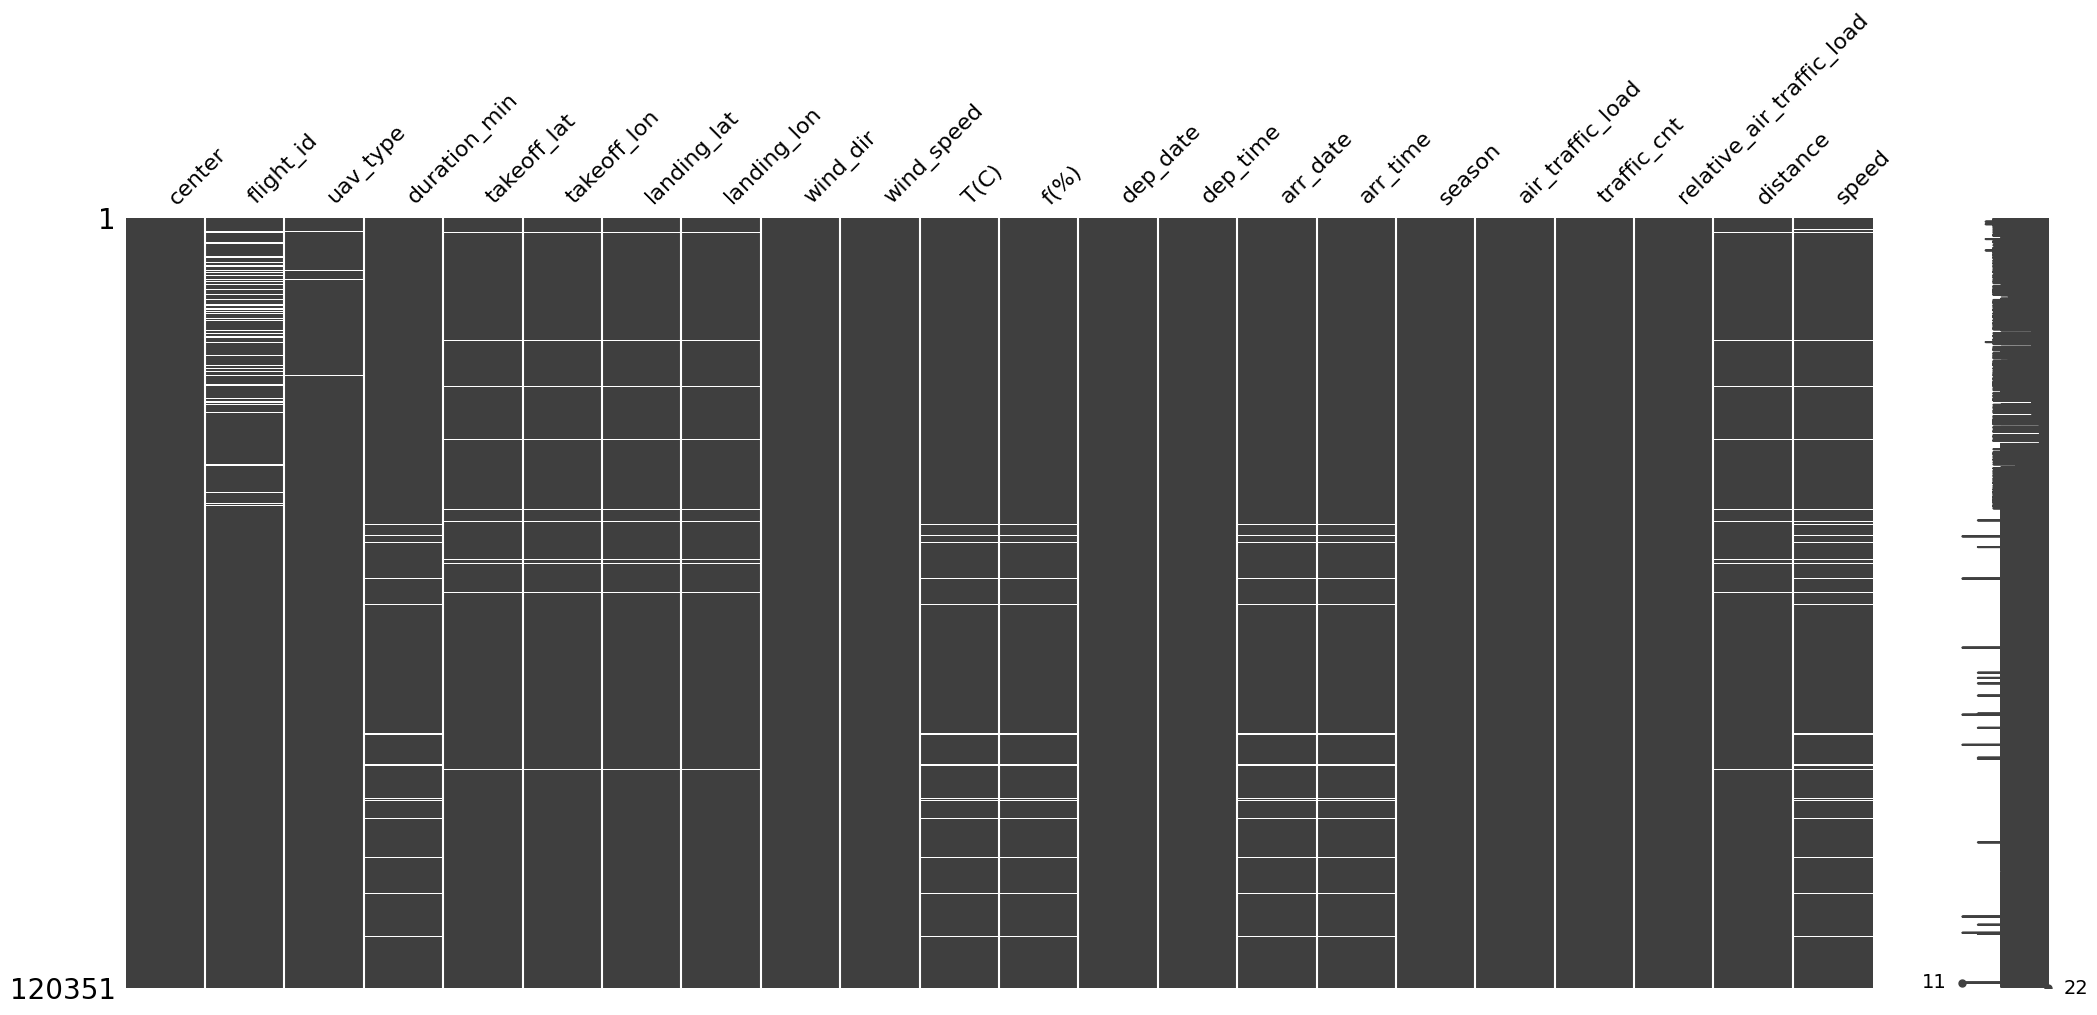

In [552]:
msno.matrix(dataset)
dataset.info()

In [553]:
dataset.to_excel("../datasets/data_new_features.xlsx")